In [2]:
#from ISUP_test.Functions.sklearn_plots import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
#import cv2
import os
import time
import datetime
import multiprocessing
import gc
import warnings

from collections import Counter
#from joblib import Parallel, delayed, dump, load
#from shapely.geometry.polygon import Polygon
from functions import *

from skimage import data
from skimage import morphology
from skimage import measure
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern, peak_local_max, canny, hog
from skimage.io import imread, imshow
from skimage.color import rgb2hed, hed2rgb, rgb2gray, label2rgb, gray2rgb, rgb2lab, rgb2yuv
from skimage.util import crop, img_as_ubyte, img_as_float, invert
from skimage.filters import threshold_otsu, threshold_local, rank, sobel
from skimage.segmentation import clear_border
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.transform import match_histograms

from sklearn import svm, metrics, preprocessing
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit,ShuffleSplit,cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.datasets import load_sample_image
from sklearn.pipeline import make_pipeline

from scipy.interpolate import UnivariateSpline
from scipy import ndimage as ndi
from scipy.spatial import Delaunay, ConvexHull

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib.colors import LinearSegmentedColormap
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white','navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet','white'])

In [17]:
path = '/home/ehsan/Documents/Tien/histopathology/ISUP_test/ISUP_images/'
grade_folders = sorted([f for f in os.listdir(path) if not f.startswith('.')]) # le if : ne pas prendre hidden files
# grade_folders : ['GS_33', 'GS_34', 'GS_43', 'GS_44', 'GS_910']

# 163 images cancer ISUP
images_33 = [image for image in os.listdir(path+grade_folders[0]) if '20X' in image] #57
images_34 = [image for image in os.listdir(path+grade_folders[1]) if '20X' in image] #62
images_43 = [image for image in os.listdir(path+grade_folders[2]) if '20X' in image] #9
images_44 = [image for image in os.listdir(path+grade_folders[3]) if '20X' in image] #16
images_910 = [image for image in os.listdir(path+grade_folders[4]) if '20X' in image] #19

images = images_33 + images_34 + images_43 + images_44 + images_910

grade_33 = ['GS_33' for i in range(len(images_33))]
grade_34 = ['GS_34' for i in range(len(images_34))]
grade_43 = ['GS_43' for i in range(len(images_43))]
grade_44 = ['GS_44' for i in range(len(images_44))]
grade_910 = ['GS_910' for i in range(len(images_910))]

grades = grade_33 + grade_34 + grade_43 + grade_44 + grade_910

labels_33 = [1 for i in range(len(images_33))]
labels_34 = [2 for i in range(len(images_34))]
labels_43 = [3 for i in range(len(images_43))]
labels_44 = [4 for i in range(len(images_44))]
labels_910 = [5 for i in range(len(images_910))]

labels = labels_33 + labels_34 + labels_43 + labels_44 + labels_910

np.savetxt('/home/ehsan/Documents/Tien/histopathology/ISUP_test/results/2019-08-26/labels.txt', labels)

In [ ]:
# Read, resize and scale images to 40X
new_height = 900
new_width = 900

t0 = time.time()

images_33_read = []
os.chdir(path+grade_folders[0])
for image_name in images_33 :
    if '10X' in image_name :
        images_33_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 4))
    elif '20X' in image_name :
        images_33_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 2))
    else :
        images_33_read.append(crop_img(imread(image_name), new_height, new_width))

images_34_read = []
os.chdir(path+grade_folders[1])
for image_name in images_34 :
    if '10X' in image_name :
        images_34_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 4))
    elif '20X' in image_name :
        images_34_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 2))
    else :
        images_34_read.append(crop_img(imread(image_name), new_height, new_width))

images_43_read = []
os.chdir(path+grade_folders[2])
for image_name in images_43 :
    if '10X' in image_name :
        images_43_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 4))
    elif '20X' in image_name :
        images_43_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 2))
    else :
        images_43_read.append(crop_img(imread(image_name), new_height, new_width))

images_44_read = []
os.chdir(path+grade_folders[3])
for image_name in images_44 :
    if '10X' in image_name :
        images_44_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 4))
    elif '20X' in image_name :
        images_44_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 2))
    else :
        images_44_read.append(crop_img(imread(image_name), new_height, new_width))

images_910_read = []
os.chdir(path+grade_folders[4])
for image_name in images_910 :
    if '10X' in image_name :
        images_910_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 4))
    elif '20X' in image_name :
        images_910_read.append(cv2_clipped_zoom(crop_img(imread(image_name), new_height, new_width), 2))
    else :
        images_910_read.append(crop_img(imread(image_name), new_height, new_width))

t1 = time.time()

#print(t1-t0) = 43 secondes

In [4]:
t0 = time.time()

images_33_read = []
os.chdir(path+grade_folders[0])
for image_name in images_33 :
    images_33_read.append(imread(image_name))

images_34_read = []
os.chdir(path+grade_folders[1])
for image_name in images_34 :
    images_34_read.append(imread(image_name))

images_43_read = []
os.chdir(path+grade_folders[2])
for image_name in images_43 :
    images_43_read.append(imread(image_name))

images_44_read = []
os.chdir(path+grade_folders[3])
for image_name in images_44 :
    images_44_read.append(imread(image_name))

images_910_read = []
os.chdir(path+grade_folders[4])
for image_name in images_910 :
    images_910_read.append(imread(image_name))

t1 = time.time()

print("time : ", t1-t0)

time :  11.733269214630127


In [ ]:
# Calculate properties for every nuclei detected
reference = imread('/home/ehsan/Documents/Tien/histopathology/ISUP_test/ISUP_images/GS_34/281_20X.jpg')
os.chdir('/home/ehsan/Documents/Tien/histopathology/ISUP_test/results/')
os.mkdir(datetime.date.today().isoformat())# yyyy-mm-dd
os.chdir('/home/ehsan/Documents/Tien/histopathology/ISUP_test/results/' + datetime.date.today().isoformat())

t_init = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #############################################################################
    t0 = time.time()
    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for i in range(0,int(len(images_33_read)/3)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_33_read[i], reference)
        props.append(p)
        nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        garbage = gc.collect()
    results = [props, nuclei_mask, eosin_mask, lumen_mask]
    with open('results_33_part_1.pickle', 'wb') as f:
         pickle.dump(results, f)

    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for i in range(int(len(images_33_read)/3),int(2*len(images_33_read)/3)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_33_read[i], reference)
        props.append(p)
        nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        garbage = gc.collect()
    results = [props, nuclei_mask, eosin_mask, lumen_mask]
    with open('results_33_part_2.pickle', 'wb') as f:
         pickle.dump(results, f)

    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for i in range(int(2*len(images_33_read)/3),len(images_33_read)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_33_read[i], reference)
        props.append(p)
        nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        garbage = gc.collect()
    results = [props, nuclei_mask, eosin_mask, lumen_mask]
    with open('results_33_part_3.pickle', 'wb') as f:
         pickle.dump(results, f)
    
    t1 = time.time()
    print('Temps images 3+3 : %f min.' % ((t1-t0)/60))
    #############################################################################
    t0 = time.time()
    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for i in range(0,int(len(images_34_read)/3)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_34_read[i], reference)
        props.append(p)
        nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        del c, l, p, nuclei, eosin, lumen
    results = [props, eosin_mask, lumen_mask]
    with open('results_34_part_1.pickle', 'wb') as f:
         pickle.dump(results, f)

    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for i in range(int(len(images_34_read)/3),int(2*len(images_34_read)/3)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_34_read[i], reference)
        props.append(p)
        nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        del c, l, p, nuclei, eosin, lumen
    results = [props, eosin_mask, lumen_mask]
    with open('results_34_part_2.pickle', 'wb') as f:
         pickle.dump(results, f)

    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for i in range(int(2*len(images_34_read)/3), len(images_34_read)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_34_read[i], reference)
        props.append(p)
        #nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        del c, l, p, nuclei, eosin, lumen
    results = [props, eosin_mask, lumen_mask]
    with open('results_34_part_3.pickle', 'wb') as f:
         pickle.dump(results, f)
    
    t1 = time.time()
    print('Temps images 3+4 : %f min.' % ((t1-t0)/60))
    #############################################################################
    t0 = time.time()
    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for image in images_43_read :
        c, l, p, nuclei, eosin, lumen = detect_nuclei(image, reference)
        props.append(p)
        nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        del c, l, p, nuclei, eosin, lumen
    results = [props, eosin_mask, lumen_mask]
    with open('results_43.pickle', 'wb') as f:
         pickle.dump(results, f)
    t1 = time.time()
    print('Temps images 4+3 : %f min.' % ((t1-t0)/60))
    #############################################################################
    t0 = time.time()
    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for image in images_44_read :
        c, l, p, nuclei, eosin, lumen = detect_nuclei(image, reference)
        props.append(p)
        nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        del c, l, p, nuclei, eosin, lumen
    results = [props, eosin_mask, lumen_mask]
    with open('results_44.pickle', 'wb') as f:
         pickle.dump(results, f)    
    t1 = time.time()
    print('Temps images 4+4 : %f min.' % ((t1-t0)/60))
    #############################################################################
    t0 = time.time()
    props = []
    nuclei_mask = []
    eosin_mask = []
    lumen_mask = []
    for image in images_910_read :
        c, l, p, nuclei, eosin, lumen = detect_nuclei(image, reference)
        props.append(p)
        nuclei_mask.append(nuclei)
        eosin_mask.append(eosin)
        lumen_mask.append(lumen)
        del c, l, p, nuclei, eosin, lumen
    results = [props, eosin_mask, lumen_mask]
    with open('results_910.pickle', 'wb') as f:
         pickle.dump(results, f)
    t1 = time.time()
    print('Temps images 9/10 : %f min.' % ((t1-t0)/60))
    #############################################################################

t_final = time.time()
print('TOTAL TIME : %f min.' % ((t_final-t_init)/60))

In [ ]:
# With the properties calculated from cell above, get the features.

# Calculate properties for every nuclei detected
reference = imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_34/281_20X.jpg')
os.chdir('/home/tien/Documents/tests/ISUP_test/results/')
os.mkdir(datetime.date.today().isoformat())# yyyy-mm-dd
os.chdir('/home/tien/Documents/tests/ISUP_test/results/' + datetime.date.today().isoformat())

t_init = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #############################################################################
    t0 = time.time()
    #neigh_features = []
    #dens_features = []
    for i in range(0,int(len(images_33_read)/3)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_33_read[i], reference)
        #neigh_features.append(neighbor_features(p, eosin, lumen))
        #dens_features.append(get_densities_feature(images_33_read[i], p, eosin, lumen))
    #neigh_dens_feat = [neigh_features, dens_features]
    with open('results_33_part_1.pickle', 'wb') as f:
         pickle.dump(results, f) # 462 Mb
    
    #neigh_features = []
    #dens_features = []
    for i in range(int(len(images_33_read)/3),int(2*len(images_33_read)/3)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_33_read[i], reference)
        #neigh_features.append(neighbor_features(p, eosin, lumen))
        #dens_features.append(get_densities_feature(images_33_read[i], p, eosin, lumen))
    #neigh_dens_feat = [neigh_features, dens_features]
    with open('results_33_part_2.pickle', 'wb') as f:
         pickle.dump(results, f) # 480 Mb
    
    #neigh_features = []
    #dens_features = []
    for i in range(int(2*len(images_33_read)/3),len(images_33_read)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_33_read[i], reference)
        #neigh_features.append(neighbor_features(p, eosin, lumen))
        #dens_features.append(get_densities_feature(images_33_read[i], p, eosin, lumen))
    #neigh_dens_feat = [neigh_features, dens_features]
    with open('results_33_part_3.pickle', 'wb') as f:
         pickle.dump(results, f) #517 Mb
    
    t1 = time.time()
    print('Temps images 3+3 : %f min.' % ((t1-t0)/60))
    #############################################################################
    t0 = time.time()
#     neigh_features = []
#     dens_features = []
    for i in range(0,int(len(images_34_read)/3)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_34_read[i], reference)
#         neigh_features.append(neighbor_features(p, eosin, lumen))
#         dens_features.append(get_densities_feature(images_34_read[i], p, eosin, lumen))
#     neigh_dens_feat = [neigh_features, dens_features]
    with open('results_34_part_1.pickle', 'wb') as f:
         pickle.dump(results, f)
    
#     neigh_features = []
#     dens_features = []
    for i in range(int(len(images_34_read)/3),int(2*len(images_34_read)/3)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_34_read[i], reference)
#         neigh_features.append(neighbor_features(p, eosin, lumen))
#         dens_features.append(get_densities_feature(images_34_read[i], p, eosin, lumen))
#     neigh_dens_feat = [neigh_features, dens_features]
    with open('results_34_part_2.pickle', 'wb') as f:
         pickle.dump(results, f)
            
#     neigh_features = []
#     dens_features = []
    for i in range(int(2*len(images_34_read)/3), len(images_34_read)):
        c, l, p, nuclei, eosin, lumen = detect_nuclei(images_34_read[i], reference)
#         neigh_features.append(neighbor_features(p, eosin, lumen))
#         dens_features.append(get_densities_feature(images_34_read[i], p, eosin, lumen))
#     neigh_dens_feat = [neigh_features, dens_features]
    with open('results_34_part_3.pickle', 'wb') as f:
         pickle.dump(results, f)
    
    t1 = time.time()
    print('Temps images 3+4 : %f min.' % ((t1-t0)/60))
    #############################################################################
    t0 = time.time()
#     neigh_features = []
#     dens_features = []

    for image in images_43_read :
        c, l, p, nuclei, eosin, lumen = detect_nuclei(image, reference)
#         neigh_features.append(neighbor_features(p, eosin, lumen))
#         dens_features.append(get_densities_feature(image, p, eosin, lumen))
#     neigh_dens_feat = [neigh_features, dens_features]
    with open('results_43.pickle', 'wb') as f:
         pickle.dump(results, f)
    t1 = time.time()
    print('Temps images 4+3 : %f min.' % ((t1-t0)/60))
    #############################################################################
    t0 = time.time()
#     neigh_features = []
#     dens_features = []
    for image in images_44_read :
        c, l, p, nuclei, eosin, lumen = detect_nuclei(image, reference)
#         neigh_features.append(neighbor_features(p, eosin, lumen))
#         dens_features.append(get_densities_feature(image, p, eosin, lumen))
#     neigh_dens_feat = [neigh_features, dens_features]
    with open('results_44.pickle', 'wb') as f:
         pickle.dump(results, f)    
    t1 = time.time()
    print('Temps images 4+4 : %f min.' % ((t1-t0)/60))
    #############################################################################
    t0 = time.time()
    neigh_features = []
    dens_features = []
    for image in images_910_read :
        c, l, p, nuclei, eosin, lumen = detect_nuclei(image, reference)
#         neigh_features.append(neighbor_features(p, eosin, lumen))
#         dens_features.append(get_densities_feature(image, p, eosin, lumen))
#     neigh_dens_feat = [neigh_features, dens_features]
    with open('results_910.pickle', 'wb') as f:
         pickle.dump(results, f)
    t1 = time.time()
    print('Temps images 9/10 : %f min.' % ((t1-t0)/60))
    #############################################################################

t_final = time.time()
print('TOTAL TIME : %f min.' % ((t_final-t_init)/60))

In [6]:
os.chdir('/home/tien/Documents/tests/ISUP_test/results/2019-07-08/')

with open('results_33_part_1.pickle', 'rb') as f:
    neigh_feat_33_1, dens_feat_33_1 = pickle.load(f)
with open('results_33_part_2.pickle', 'rb') as f:
    neigh_feat_33_2, dens_feat_33_2 = pickle.load(f)
with open('results_33_part_3.pickle', 'rb') as f:
    neigh_feat_33_3, dens_feat_33_3 = pickle.load(f)

neigh_feat_33 = neigh_feat_33_1 + neigh_feat_33_2 + neigh_feat_33_3
dens_feat_33 = dens_feat_33_1 + dens_feat_33_2 + dens_feat_33_3
del neigh_feat_33_1, neigh_feat_33_2, neigh_feat_33_3
del dens_feat_33_1, dens_feat_33_2, dens_feat_33_3
# #############################################################
with open('results_34_part_1.pickle', 'rb') as f:
    neigh_feat_34_1, dens_feat_34_1 = pickle.load(f)
with open('results_34_part_2.pickle', 'rb') as f:
    neigh_feat_34_2, dens_feat_34_2 = pickle.load(f)
with open('results_34_part_3.pickle', 'rb') as f:
    neigh_feat_34_3, dens_feat_34_3 = pickle.load(f)

neigh_feat_34 = neigh_feat_34_1 + neigh_feat_34_2 + neigh_feat_34_3
dens_feat_34 = dens_feat_34_1 + dens_feat_34_2 + dens_feat_34_3
del neigh_feat_34_1, neigh_feat_34_2, neigh_feat_34_3
del dens_feat_34_1, dens_feat_34_2, dens_feat_34_3
#############################################################   
with open('results_43.pickle', 'rb') as f:
    neigh_feat_43, dens_feat_43 = pickle.load(f)

#############################################################
with open('results_44.pickle', 'rb') as f:
    neigh_feat_44, dens_feat_44 = pickle.load(f)

#############################################################
with open('results_910.pickle', 'rb') as f:
    neigh_feat_910, dens_feat_910 = pickle.load(f)

In [21]:
neighfeat_33_mean = [np.mean(np.reshape(np.array(neigh_feat_33), (len(neigh_feat_33),1))[i][0], axis=0) for i in range(len(neigh_feat_33))] # mettre en format : (# image x # features) où les features des noyaux d'une image sont moyennés
neighfeat_34_mean = [np.mean(np.reshape(np.array(neigh_feat_34), (len(neigh_feat_34),1))[i][0], axis=0) for i in range(len(neigh_feat_34))]
neighfeat_43_mean = [np.mean(np.reshape(np.array(neigh_feat_43), (len(neigh_feat_43),1))[i][0], axis=0) for i in range(len(neigh_feat_43))]
neighfeat_44_mean = [np.mean(np.reshape(np.array(neigh_feat_44), (len(neigh_feat_44),1))[i][0], axis=0) for i in range(len(neigh_feat_44))]
neighfeat_910_mean = [np.mean(np.reshape(np.array(neigh_feat_910), (len(neigh_feat_910),1))[i][0], axis=0) for i in range(len(neigh_feat_910))]

neigh_feat = np.vstack((np.array(neighfeat_33_mean),
                           np.array(neighfeat_34_mean),
                           np.array(neighfeat_43_mean),
                           np.array(neighfeat_44_mean),
                           np.array(neighfeat_910_mean))) #shape : (163 x 26)

dens_feat = np.vstack((np.array(dens_feat_33),
                       np.array(dens_feat_34),
                       np.array(dens_feat_43),
                       np.array(dens_feat_44),
                       np.array(dens_feat_910))) #shape : (163 x 12)

neigh_dens_feat = np.hstack((neigh_feat, dens_feat)) #shape : (163 x 38)


np.savetxt('neigh_feat.txt', neigh_feat)
np.savetxt('dens_feat.txt', dens_feat)
np.savetxt('neigh_dens_feat.txt', neigh_dens_feat)
np.savetxt('labels.txt', labels)

In [8]:
os.chdir('/home/tien/Documents/tests/ISUP_test/results/2019-06-25/')

with open('neighfeat_33_part_1.pickle', 'rb') as f:
    neighfeat_33_1 = pickle.load(f)
with open('neighfeat_33_part_2.pickle', 'rb') as f:
    neighfeat_33_2 = pickle.load(f)
with open('neighfeat_33_part_3.pickle', 'rb') as f:
    neighfeat_33_3 = pickle.load(f)

neighfeat_33 = neighfeat_33_1 + neighfeat_33_2 + neighfeat_33_3
# #############################################################
with open('neighfeat_34_part_1.pickle', 'rb') as f:
    neighfeat_34_1 = pickle.load(f)
with open('neighfeat_34_part_2.pickle', 'rb') as f:
    neighfeat_34_2 = pickle.load(f)
with open('neighfeat_34_part_3.pickle', 'rb') as f:
    neighfeat_34_3 = pickle.load(f)

neighfeat_34 = neighfeat_34_1 + neighfeat_34_2 + neighfeat_34_3

#############################################################   
with open('neighfeat_43.pickle', 'rb') as f:
    neighfeat_43 = pickle.load(f)

#############################################################
with open('neighfeat_44.pickle', 'rb') as f:
    neighfeat_44 = pickle.load(f)

#############################################################
with open('neighfeat_910.pickle', 'rb') as f:
    neighfeat_910 = pickle.load(f)

In [31]:
os.chdir('/home/tien/Documents/tests/ISUP_test/results/2019-06-26/')
neighfeat_33_mean = [np.mean(np.reshape(np.array(neighfeat_33), (len(neighfeat_33),1))[i][0], axis=0) for i in range(len(neighfeat_33))] # mettre en format : (# image x # features) où les features des noyaux d'une image sont moyennés
neighfeat_34_mean = [np.mean(np.reshape(np.array(neighfeat_34), (len(neighfeat_34),1))[i][0], axis=0) for i in range(len(neighfeat_34))]
neighfeat_43_mean = [np.mean(np.reshape(np.array(neighfeat_43), (len(neighfeat_43),1))[i][0], axis=0) for i in range(len(neighfeat_43))]
neighfeat_44_mean = [np.mean(np.reshape(np.array(neighfeat_44), (len(neighfeat_44),1))[i][0], axis=0) for i in range(len(neighfeat_44))]
neighfeat_910_mean = [np.mean(np.reshape(np.array(neighfeat_910), (len(neighfeat_910),1))[i][0], axis=0) for i in range(len(neighfeat_910))]

neighfeat_epi = np.vstack((np.array(neighfeat_33_mean),
                           np.array(neighfeat_34_mean),
                           np.array(neighfeat_43_mean),
                           np.array(neighfeat_44_mean),
                           np.array(neighfeat_910_mean))) #shape : (163 x 26)
np.savetxt('neighfeat_epi.txt', neighfeat_epi)
np.savetxt('labels.txt', labels)

In [16]:
os.chdir('/home/tien/Documents/tests/ISUP_test/results/2019-06-25/')

with open('props_33_part_1.pickle', 'rb') as f:
    props_33_1 = pickle.load(f)
with open('props_33_part_2.pickle', 'rb') as f:
    props_33_2 = pickle.load(f)
with open('props_33_part_3.pickle', 'rb') as f:
    props_33_3 = pickle.load(f)

props_33 = props_33_1 + props_33_2 + props_33_3
polyfeat_33 = polygon_features(props_33)
del props_33_1, props_33_2, props_33_3, props_33
#############################################################
with open('props_34_part_1.pickle', 'rb') as f:
    props_34_1 = pickle.load(f)
with open('props_34_part_2.pickle', 'rb') as f:
    props_34_2 = pickle.load(f)
with open('props_34_part_3.pickle', 'rb') as f:
    props_34_3 = pickle.load(f)

props_34 = props_34_1 + props_34_2 + props_34_3
polyfeat_34 = polygon_features(props_34)
del props_34_1, props_34_2, props_34_3, props_34
#############################################################   
with open('props_43.pickle', 'rb') as f:
    props_43 = pickle.load(f)
polyfeat_43 = polygon_features(props_43)
del props_43
#############################################################
with open('props_44.pickle', 'rb') as f:
    props_44 = pickle.load(f)
polyfeat_44 = polygon_features(props_44)
del props_44
#############################################################
with open('props_910.pickle', 'rb') as f:
    props_910 = pickle.load(f)
polyfeat_910 = polygon_features(props_910)
del props_910

In [25]:
polyfeat_all = np.vstack((polyfeat_33, polyfeat_34, polyfeat_43, polyfeat_44, polyfeat_910))
poly_neigh_all = np.hstack((polyfeat_all, neighfeat_all))
np.savetxt('polyfeat_all.txt', polyfeat_all)
np.savetxt('poly_neigh_all.txt', poly_neigh_all)

In [5]:
points = points_33 + points_34 + points_43 + points_44 + points_910
polygons = polygons_33 + polygons_34 + polygons_43 + polygons_44 + polygons_910
areas = areas_33 + areas_34 + areas_43 + areas_44 + areas_910

In [6]:
# GÉNÉRATION DU DATAFRAME

df = pd.DataFrame(data=np.array([grades, images, polygons, areas, points]).transpose(),
                   columns=['grades', 'images', 'polygons', 'polygon_areas', 'points'])
df.to_pickle('/home/tien/Documents/tests/ISUP_test/results/dataframe_ISUP_20X.pkl')

## Generate neighborhood and densities features

In [14]:
# Run on desktop...
#os.chdir('/home/ehsan/Documents/Tien/results/2019-07-08/')
os.chdir('/home/ehsan/Documents/Tien/histopathology/ISUP_test/results/2019-07-08/')

t0 = time.time()

with open('results_33_part_1.pickle', 'rb') as f:
    props_33_1, nuclei_mask_33_1, eosin_mask_33_1, lumen_mask_33_1 = pickle.load(f)
with open('results_33_part_2.pickle', 'rb') as f:
    props_33_2, nuclei_mask_33_2, eosin_mask_33_2, lumen_mask_33_2 = pickle.load(f)
with open('results_33_part_3.pickle', 'rb') as f:
    props_33_3, nuclei_mask_33_3, eosin_mask_33_3, lumen_mask_33_3 = pickle.load(f)

props_33 = props_33_1 + props_33_2 + props_33_3
del props_33_1, props_33_2, props_33_3

nuclei_mask_33 = nuclei_mask_33_1 + nuclei_mask_33_2 + nuclei_mask_33_3
del nuclei_mask_33_1, nuclei_mask_33_2, nuclei_mask_33_3

eosin_mask_33 = eosin_mask_33_1 + eosin_mask_33_2 + eosin_mask_33_3
del eosin_mask_33_1, eosin_mask_33_2, eosin_mask_33_3

lumen_mask_33 = lumen_mask_33_1 + lumen_mask_33_2 + lumen_mask_33_3
del lumen_mask_33_1, lumen_mask_33_2, lumen_mask_33_3

densities_features_33 = np.zeros((len(props_33), 16)) # 16 densities features (patches)
densities_wholeimage_features_33 = np.zeros((len(props_33),1))
neigh_features_33 = []
for i in range(len(props_33)) : # itération sur les images
    neigh_features_33.append(neighbor_features(props_33[i], eosin_mask_33[i], lumen_mask_33[i]))
    densities_features_33[i] = get_densities_patches_feature(props_33[i], nuclei_mask_33[i], eosin_mask_33[i], lumen_mask_33[i])
    densities_wholeimage_features_33[i] = get_densities_wholeimage_feature(nuclei_mask_33[i], eosin_mask_33[i])
      
del nuclei_mask_33, lumen_mask_33, props_33, eosin_mask_33

# # #############################################################
with open('results_34_part_1.pickle', 'rb') as f:
    props_34_1, nuclei_mask_34_1, eosin_mask_34_1, lumen_mask_34_1 = pickle.load(f)
with open('results_34_part_2.pickle', 'rb') as f:
    props_34_2, nuclei_mask_34_2, eosin_mask_34_2, lumen_mask_34_2 = pickle.load(f)
with open('results_34_part_3.pickle', 'rb') as f:
    props_34_3, nuclei_mask_34_3, eosin_mask_34_3, lumen_mask_34_3 = pickle.load(f)

props_34 = props_34_1 + props_34_2 + props_34_3
del props_34_1, props_34_2, props_34_3

nuclei_mask_34 = nuclei_mask_34_1 + nuclei_mask_34_2 + nuclei_mask_34_3
del nuclei_mask_34_1, nuclei_mask_34_2, nuclei_mask_34_3

eosin_mask_34 = eosin_mask_34_1 + eosin_mask_34_2 + eosin_mask_34_3
del eosin_mask_34_1, eosin_mask_34_2, eosin_mask_34_3

lumen_mask_34 = lumen_mask_34_1 + lumen_mask_34_2 + lumen_mask_34_3
del lumen_mask_34_1, lumen_mask_34_2, lumen_mask_34_3

densities_features_34 = np.zeros((len(props_34), 16))
densities_wholeimage_features_34 = np.zeros((len(props_34),1))
neigh_features_34 = []
for i in range(len(props_34)) :
    neigh_features_34.append(neighbor_features(props_34[i], eosin_mask_34[i], lumen_mask_34[i]))
    densities_features_34[i] = get_densities_patches_feature(props_34[i], nuclei_mask_34[i], eosin_mask_34[i], lumen_mask_34[i])
    densities_wholeimage_features_34[i] = get_densities_wholeimage_feature(nuclei_mask_34[i], eosin_mask_34[i])

del nuclei_mask_34, lumen_mask_34, props_34, eosin_mask_34

#############################################################   
with open('results_43.pickle', 'rb') as f:
    props_43, nuclei_mask_43, eosin_mask_43, lumen_mask_43 = pickle.load(f)

densities_features_43 = np.zeros((len(props_43), 16))
densities_wholeimage_features_43 = np.zeros((len(props_43),1))
neigh_features_43 = []
for i in range(len(props_43)) :
    neigh_features_43.append(neighbor_features(props_43[i], eosin_mask_43[i], lumen_mask_43[i]))
    densities_features_43[i] = get_densities_patches_feature(props_43[i], nuclei_mask_43[i], eosin_mask_43[i], lumen_mask_43[i])
    densities_wholeimage_features_43[i] = get_densities_wholeimage_feature(nuclei_mask_43[i], eosin_mask_43[i])

del props_43, nuclei_mask_43, lumen_mask_43, eosin_mask_43
#############################################################
with open('results_44.pickle', 'rb') as f:
    props_44, nuclei_mask_44, eosin_mask_44, lumen_mask_44 = pickle.load(f)

densities_features_44 = np.zeros((len(props_44), 16))
densities_wholeimage_features_44 = np.zeros((len(props_44),1))
neigh_features_44 = []
for i in range(len(props_44)) :
    neigh_features_44.append(neighbor_features(props_44[i], eosin_mask_44[i], lumen_mask_44[i]))
    densities_features_44[i] = get_densities_patches_feature(props_44[i], nuclei_mask_44[i], eosin_mask_44[i], lumen_mask_44[i])
    densities_wholeimage_features_44[i] = get_densities_wholeimage_feature(nuclei_mask_44[i], eosin_mask_44[i])

del props_44, nuclei_mask_44, lumen_mask_44, eosin_mask_44
#############################################################
with open('results_910.pickle', 'rb') as f:
    props_910, nuclei_mask_910, eosin_mask_910, lumen_mask_910 = pickle.load(f)

densities_features_910 = np.zeros((len(props_910), 16))
densities_wholeimage_features_910 = np.zeros((len(props_910),1))
neigh_features_910 = []
for i in range(len(props_910)) :
    neigh_features_910.append(neighbor_features(props_910[i], eosin_mask_910[i], lumen_mask_910[i]))
    densities_features_910[i] = get_densities_patches_feature(props_910[i], nuclei_mask_910[i], eosin_mask_910[i], lumen_mask_910[i])
    densities_wholeimage_features_910[i] = get_densities_wholeimage_feature(nuclei_mask_910[i], eosin_mask_910[i])

del props_910, nuclei_mask_910, lumen_mask_910, eosin_mask_910

print((time.time() - t0)/60)

19.196848746140798


In [6]:
os.getcwd()

'/home/ehsan/Documents/Tien/histopathology/ISUP_test/results/2019-07-08'

In [16]:
os.chdir('/home/ehsan/Documents/Tien/histopathology/ISUP_test/results/2019-08-26/')

neighfeat_33_mean = [np.mean(np.reshape(np.array(neigh_features_33), (len(neigh_features_33),1))[i][0], axis=0) for i in range(len(neigh_features_33))] # mettre en format : (# image x # features) où les features des noyaux d'une image sont moyennés
neighfeat_34_mean = [np.mean(np.reshape(np.array(neigh_features_34), (len(neigh_features_34),1))[i][0], axis=0) for i in range(len(neigh_features_34))]
neighfeat_43_mean = [np.mean(np.reshape(np.array(neigh_features_43), (len(neigh_features_43),1))[i][0], axis=0) for i in range(len(neigh_features_43))]
neighfeat_44_mean = [np.mean(np.reshape(np.array(neigh_features_44), (len(neigh_features_44),1))[i][0], axis=0) for i in range(len(neigh_features_44))]
neighfeat_910_mean = [np.mean(np.reshape(np.array(neigh_features_910), (len(neigh_features_910),1))[i][0], axis=0) for i in range(len(neigh_features_910))]

neigh_feat = np.vstack((np.array(neighfeat_33_mean),
                           np.array(neighfeat_34_mean),
                           np.array(neighfeat_43_mean),
                           np.array(neighfeat_44_mean),
                           np.array(neighfeat_910_mean))) #shape : (163 x 26)
np.savetxt('neigh_feat.txt', neigh_feat)

dens_feat = np.vstack((densities_features_33,
                       densities_features_34,
                       densities_features_43,
                       densities_features_44,
                       densities_features_910)) #(163 x 16)
np.savetxt('dens_feat.txt', dens_feat)

dens_wholeimg_feat = np.vstack((densities_wholeimage_features_33,
                                densities_wholeimage_features_34,
                                densities_wholeimage_features_43,
                                densities_wholeimage_features_44,
                                densities_wholeimage_features_910)) # (163 x 1)
np.savetxt('dens_wholeimg_feat.txt', dens_wholeimg_feat)

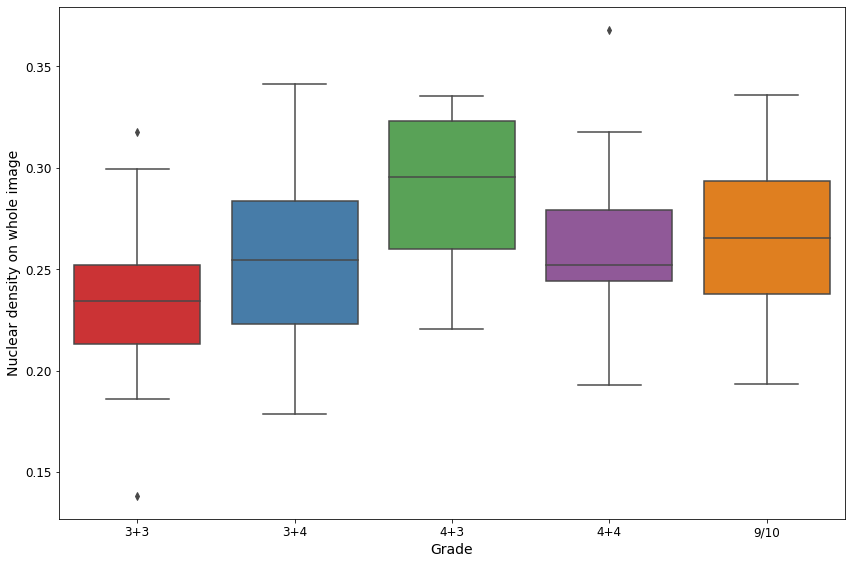

In [8]:
densities_wholeimg = [densities_wholeimage_features_33, densities_wholeimage_features_34, densities_wholeimage_features_43, densities_wholeimage_features_44, densities_wholeimage_features_910]
plt.figure(figsize=(12,8))
#sns.set(style="whitegrid")
#sns.set_context("talk")
ax = sns.boxplot(data=np.array(densities_wholeimg), palette="Set1")
ax.set_xticklabels(['3+3', '3+4', '4+3', '4+4', '9/10'])
ax.set_ylabel('Nuclear density on whole image')
ax.set_xlabel('Grade')
plt.tight_layout()
plt.show()

In [17]:
# closing : dilation -> erosion
# opening : erosion -> dilation
reference = imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_33/207_20X.jpg')
img = imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_33/1070_20X.jpg')

matched = match_histograms(img, reference, multichannel=True)

matched_hed = rgb2hed(matched)
matched_hema = rescale_intensity(matched_hed[:,:,0], out_range=(0,1))

img = img_as_ubyte(matched_hema)

block_size = 55 #35
selem = morphology.disk(5)

closed_img = morphology.closing(img, selem=selem)

local_thresh = threshold_local(closed_img, block_size, offset=10) #offset=10
close_thresh = np.bitwise_not(closed_img > local_thresh)
open_close_thresh_new = morphology.opening(close_thresh, selem)

/home/tien/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [10]:
img = img_as_ubyte(rgb2gray(imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_33/1070_20X.jpg')))

block_size = 55 #35
selem = morphology.disk(5)

closed_img = morphology.closing(img, selem=selem)

local_thresh = threshold_local(closed_img, block_size, offset=10) #offset=10
close_thresh = np.bitwise_not(closed_img > local_thresh)
open_close_thresh_old = morphology.opening(close_thresh, selem)

/home/tien/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


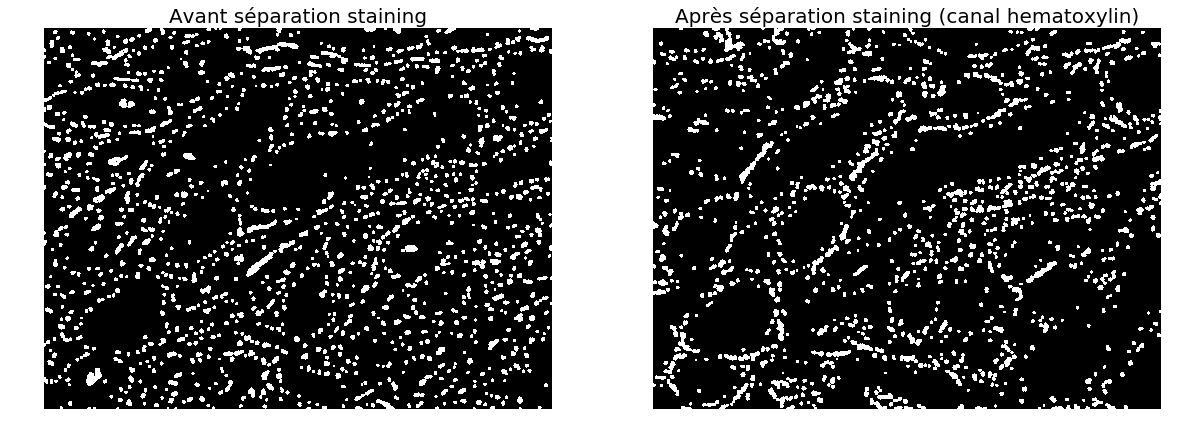

In [18]:
f, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].imshow(open_close_thresh_old, cmap=plt.cm.gray)
ax[0].set_title('Avant séparation staining', fontsize=20)
ax[1].imshow(open_close_thresh_new, cmap=plt.cm.gray)
ax[1].set_title('Après séparation staining (canal hematoxylin)', fontsize=20)
for a in ax:
    a.axis('off')

plt.savefig('/home/tien/Documents/presentations/mask_differences.png', transparent=True)    
plt.show()

In [18]:
labels_old, num_old = measure.label(open_close_thresh_new, connectivity=2, return_num=True)

In [20]:
%matplotlib qt
image = imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_33/1070_20X.jpg')

distance = ndi.distance_transform_edt(open_close_thresh_new)
local_max = peak_local_max(distance, indices=False, footprint=selem, labels=open_close_thresh_new)
markers = ndi.label(local_max)[0]
labels = morphology.watershed(-distance, markers, mask=open_close_thresh_new)


cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white','navy'])

fig, axes = plt.subplots(2,2, figsize=(17, 10), sharex=True, sharey=True)
ax = axes.ravel()

# ax[0].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
# ax[0].set_title('Distances')
# ax[1].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
# ax[1].set_title('Separated objects')
ax[0].imshow(open_close_thresh_new, cmap=plt.cm.gray)
ax[0].set_title('Hematoxylin channel', fontsize=20)
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances', fontsize=20)
ax[2].imshow(labels_old, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Overlapping nuclei', fontsize=20)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[3].set_title('Separated nuclei', fontsize=20)

for a in ax:
    a.set_axis_off()

In [23]:
props_watershed = measure.regionprops(labels, intensity_image=img)
#objects = ndi.find_objects(labels_CT) # donne l'emplacement des objets

list_areas = [props_watershed[i].area for i in range(len(props_watershed))]
avg_area = np.mean(np.array(list_areas))

#eroded_labels = morphology.opening(labels_CT_no_pale_obj, selem=selem)
labels_CT_no_small_obj_watershed = morphology.remove_small_objects(labels, min_size=0.20*avg_area)

#labels_mask = labels_CT_no_small_obj > 0

#contours = measure.find_contours(labels_CT_no_small_obj_watershed, level=np.mean(labels_CT_no_small_obj_watershed)) #level=value along which to find contours in the array
props_final_watershed = measure.regionprops(labels_CT_no_small_obj_watershed, intensity_image=img, coordinates='xy')

In [37]:
%matplotlib qt
f, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(labels_mask, cmap=plt.cm.gray)
# ax[0].set_title('original')
# ax[1].set_title('matched')
# ax[1].imshow(img_as_ubyte(rgb2gray(matched)), cmap=plt.cm.gray)

/home/tien/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


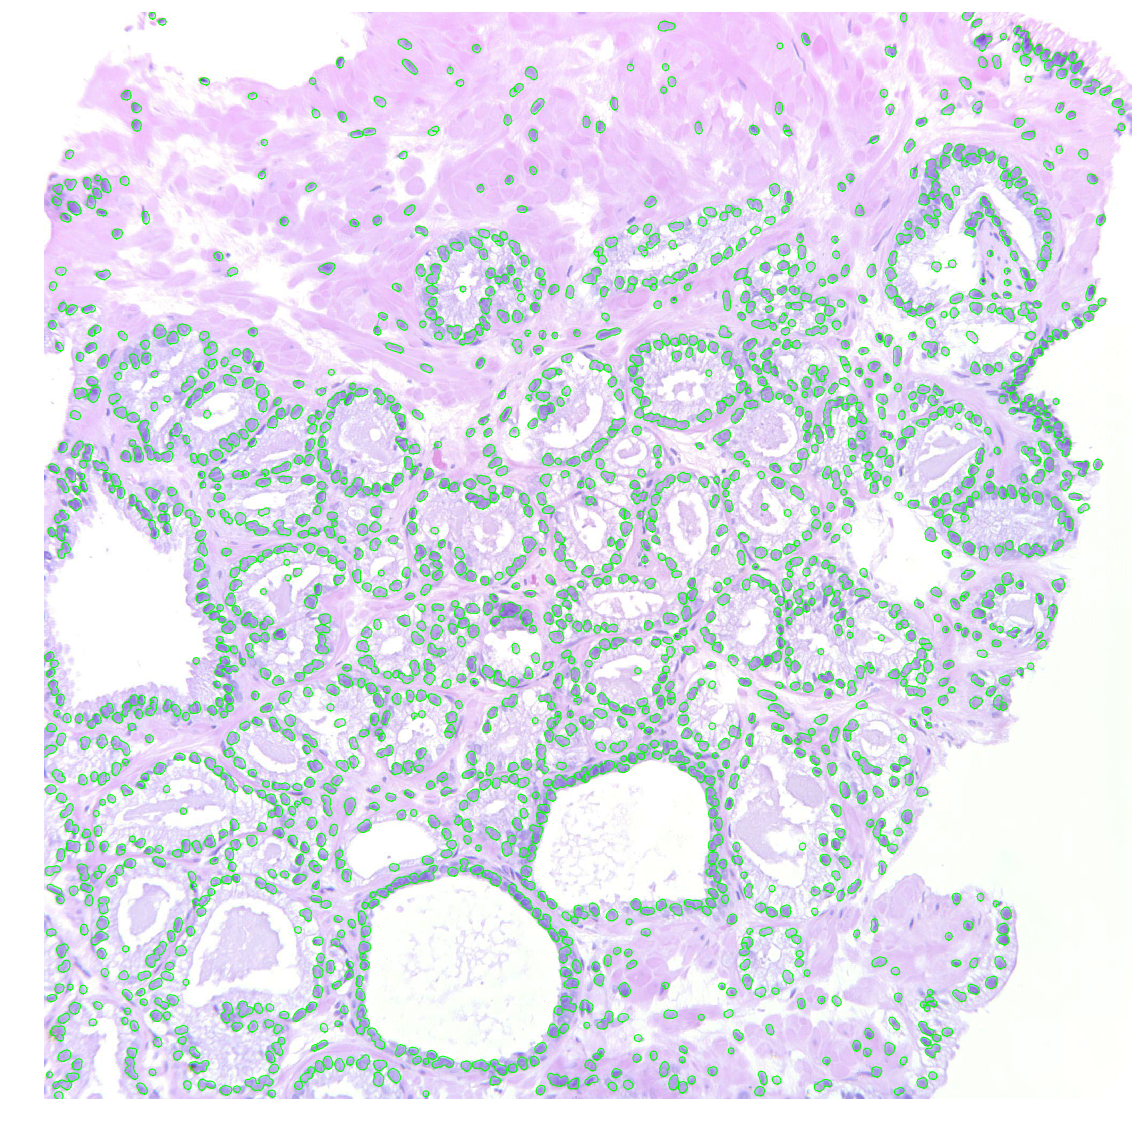

In [2]:
img = imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_33/255_20X.jpg')
ref = imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_33/207_20X.jpg')

contours, labels, props = detect_nuclei(img, ref)

f, ax = plt.subplots(figsize=(20,20))
ax.imshow(img)
for n, contour in enumerate(contours) :
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='lime')
ax.axis('off')
plt.show()